## Import

In [2]:
import math
import torch
import datetime
from Loss import *
import numpy as np
from utils import *
import torch.nn as nn
from Model import LCT
from Dataset import *
import torchvision.models as models
from torch.utils.data import DataLoader

## Train function

In [2]:
def train(model , train_dataloader, valid_dataloader, num_epochs, loss, opt):
    """
    Train a model

    * Input parameter:
    1. model                : model to be trained         
    2. train_dataloader     : dataloader of training dataset
    3. valid_dataloader     : dataloader of validation dataset
    4. num_epochs           : max # of epoch
    5. loss                 : loss function
    6. opt                  : optimizer 

    * Some Important parameter
    1. train_loss_log       : log of train loss
    2. valid_loss_log       : log of valid loss
    3. F1_score_log         : log of F1-score loss

    * Output:
    None
    """

    train_loss_log      = []
    valid_loss_log      = []
    F1_score_log        = []
    learning_rate_log   = []
    best_val_loss       = float('inf')
    record_datas        = {}

    loss_bce = loss
    
    optimizer = opt

    # get start time
    start_time = datetime.datetime.now()
    
    # train
    
    
    for epoch in range(num_epochs):
        print(f"epoch [{epoch+1:2d}/{num_epochs}]:")
        
        train_loss_all = 0
        epoch_step = 0

        optimizer = step_lr(epoch, optimizer)
        learning_rate_log.append(optimizer.param_groups[0]['lr'])

        model.train()
        for i, data in enumerate(train_dataloader):
            window_value, label = data
            # label = label.type(torch.float32)
            # label = label.view(1, label.shape[0])
            # label = label.transpose(0,1)
            window_value, label = window_value.to(get_device()), label.to(get_device())

            optimizer.zero_grad()
            outputs = model(window_value)
            if torch.isnan(outputs).any():
                print(f"nan occur!")

            batch_loss = loss_bce(outputs, label)
            batch_loss.backward()
            optimizer.step()

            train_loss_all += batch_loss.item()
            epoch_step +=1
            processbar(
                now_process=i + 1, 
                all=len(train_dataloader), 
                total_len=30, 
                info=f"{i + 1:4d}/{len(train_dataloader):4d} batches of data have been trained.",
                needed_clear = True
            )

        
        train_avg_loss = train_loss_all / epoch_step
        train_loss_log.append(train_avg_loss)

        # validation
        model.eval()
        with torch.no_grad():
            valid_loss_all = 0
            val_step = 0
            TP = 0
            FP = 0
            FN = 0
            for i, data in enumerate(valid_dataloader):
                window_value, label = data
                # label = label.type(torch.float32)
                # label = label.view(1, label.shape[0])
                # label = label.transpose(0,1)
                window_value, label = window_value.to(get_device()), label.to(get_device())

                outputs = model(window_value)

                batch_loss = loss_bce(outputs, label)
                
                # get TP, FP, FN and F1-score
                _, preds = torch.max(outputs, dim=1)
                
                TP += (label * preds).sum()
                FP += ((1-label) * preds).sum()
                FN += (label * (1-preds)).sum()
                

                valid_loss_all += batch_loss.item()
                val_step +=1
                processbar(
                    now_process=i + 1, 
                    all=len(valid_dataloader), 
                    total_len=30, 
                    info=f"{i + 1:4d}/{len(valid_dataloader):4d} batches of data have been validated.",
                    needed_clear = True
                )
        
            valid_avg_loss = valid_loss_all / val_step
            valid_loss_log.append(valid_avg_loss)

        F1_score = TP / (TP + 1/2 * FP + 1/2 * FN)
        F1_score_log.append(F1_score)

        # print message
        print(f"train loss {train_avg_loss:.4f}, valid loss {valid_avg_loss:.4f}, F1-score: {F1_score:.4f}")
        
        # record data
        record_datas["train_loss_log"]      = train_loss_log
        record_datas["valid_loss_log"]      = valid_loss_log
        record_datas["F1-score_log"]        = F1_score_log
        record_datas["learning_rate_log"]   = learning_rate_log
        record_log(record_datas=record_datas)

        # save best model
        if valid_avg_loss < best_val_loss:
            best_val_loss = valid_avg_loss
            print("Saving better model...")
            torch.save(model.state_dict(), "./model/best_model.pth")
            print("Saving better model complete.")
            
        print("========================================================")
        
        # save newest model
        torch.save(model.state_dict(), "./model/newest_model.pth")

    cost_time = datetime.datetime.now() - start_time
    print(f"Cost {cost_time:.2f} to training.")



## Main function

In [3]:
def main():
    """
    Main function to train model

    * Input parameter: None

    * Some Important parameter
    1. batch_size       : batch size(hyper parameter)
    2. num_epochs       : max epoch (hyper parameter)
    3. model            : model     (hyper parameter)
    4. train_dataset    : training dataset
    5. train_dataloader : dataloader of training dataset
    4. valid_dataset    : validation dataset
    5. valid_dataloader : dataloader of validation dataset

    * Output:
    None
    """

    # hyper parameter
    batch_size = 300
    num_epochs = 100
    lr = 1e-3
    loss_wbce = nn.CrossEntropyLoss(weight=torch.Tensor([194000/194000, 194000/600]).to(get_device()))

    model = LCT(d_model=128)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=0.02)



    model.to(get_device())
    #model.to("cuda:1")
    #model = nn.DataParallel(model, device_ids=[i for i in range(torch.cuda.device_count())])
    model = nn.DataParallel(model, device_ids=[1, 2, 3])
    
    print("Loading training dataset...")
    train_dataset = multi_dataset(num_of_dataset = 1)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    print("Loading training dataset complete.")

    print("Loading validation dataset...")
    valid_dataset = EDFdataset(
        dataset_folder_path="/homes/nfs/caslab_bs/Desktop/Dennis/physionet.org/files/chbmit/1.0.0/chb06/"
    )
    valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
    print("Loading validation dataset complete.")

    print("Start training...")
    train(
        model=model,
        train_dataloader=train_dataloader, 
        num_epochs=num_epochs, 
        valid_dataloader=valid_dataloader, 
        loss=loss_wbce, 
        opt=optimizer
    )
    print("Training complete.")

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [3]:
import torch
test= EDFdataset(dataset_folder_path="../EEG_old/EEGDataset/chb03/")

data = torch.rand(2, 1, 23, 256).to(get_device())
loss_wbce = nn.CrossEntropyLoss(weight=torch.Tensor([194000/194000, 194000/600]).to(get_device()))
model = LCT(128).to(get_device())
model = nn.DataParallel(model, device_ids=[1, 2, 3])

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=0.02)
optimizer.zero_grad()
outputs = model(data)
loss = loss_wbce(outputs, torch.LongTensor([1, 0]).to(get_device()))

loss.backward()
optimizer.step()
print("sucess")

|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■| 1/ 1 edf file processed.
sucess


## Plot

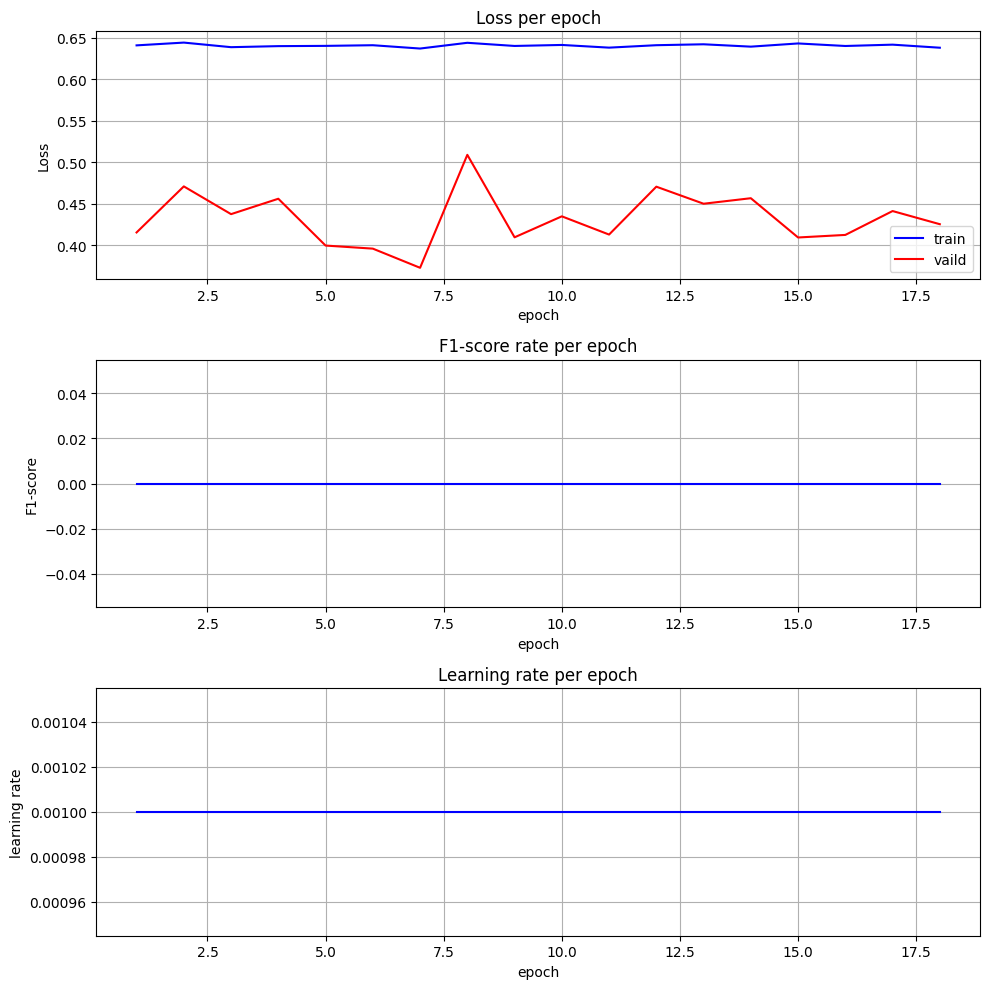

In [ ]:
import matplotlib.pyplot as plt

train_loss = []
with open("./log/" + "train_loss_log.txt","r") as f:
    train_loss = f.read().split(",")[:-1]
    for i in range(len(train_loss)):
        train_loss[i] = float(train_loss[i])

vaild_loss = []
with open("./log/" + "valid_loss_log.txt","r") as f:
    vaild_loss = f.read().split(",")[:-1]
    for i in range(len(vaild_loss)):
        vaild_loss[i] = float(vaild_loss[i])

learning_rate = []
with open("./log/" + "learning_rate_log.txt","r") as f:
    learning_rate = f.read().split(",")[:-1]
    for i in range(len(learning_rate)):
        learning_rate[i] = float(learning_rate[i])

F1_score = []
with open("./log/" + "F1-score_log.txt","r") as f:
    F1_score = f.read().split(",")[:-1]
    for i in range(len(F1_score)):
        F1_score[i] = float(F1_score[i])

fig, axes = plt.subplots(3,1, figsize = (10,10))

axes[0].grid(True)
axes[0].set_title("Loss per epoch")
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Loss")
axes[0].plot(list(range(1,len(train_loss)+1)), train_loss,'b')
axes[0].plot(list(range(1,len(vaild_loss)+1)), vaild_loss,'r')
axes[0].legend(["train","vaild"])

axes[1].grid(True)
axes[1].set_title("F1-score rate per epoch")
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("F1-score")
axes[1].plot(list(range(1,len(F1_score)+1)), F1_score,'b')


axes[2].grid(True)
axes[2].set_title("Learning rate per epoch")
axes[2].set_xlabel("epoch")
axes[2].set_ylabel("learning rate")
axes[2].plot(list(range(1,len(learning_rate)+1)), learning_rate,'b')

plt.tight_layout()
plt.show()